<a href="https://colab.research.google.com/github/neeluvermaiitj/Deep-Learning/blob/main/Chart_Image_Classification_using_2_layer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Question 4.**

You have to develop a CNN based classication architecture for clas-
sifying a given chart image to one of ve chart classes, namely \Line",\Dot Line",\Horizontal
Bar",\Vertical Bar", and \Pie" chart.

Task 0: Learn how CNN is implemented for image classication in PyTorch from the fol-
lowing blog:
PyTorch CNN example

**Task 1:** Download the dataset from drive link given below.
Dataset link
Use train and val images for training and validation in an appropriate ratio (e.g., 80%
for training and 20 % for validating). The CSV le contains corresponding labels for the
images. TA shall provide dataloader code.
**Task 2:** Implement a two-layer Convolutional Neural Network. (Hint: use learning from
Task-0), and calculate accuracy, loss and plot the obtained loss. Brie
y write your obser-
vation and submit your code so that we can evaluate your implementation at our end. (30
points)

# Setting the Data Set `path variable` (IMPORTANT)

Please update this path for **`CHART`** dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
chart_data_path = "/content/drive/My Drive/ML_Assignment_5/charts"                # Update this variable with the exact path for CHART dataset

# Importing the modules

Importing all the modules 

In [ ]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import random
import os
import pathlib


# Loading the dataset


## Loading the `class labels`

In [ ]:
# loading dataset
train_val_file_name = os.path.join(chart_data_path, 'train_val.csv')
train_val = pd.read_csv(train_val_file_name)

train_val.head()

,image_index,type
0,0,vbar_categorical
1,1,vbar_categorical
2,2,vbar_categorical
3,3,vbar_categorical
4,4,vbar_categorical


In [ ]:
# encoding the class labels 
labels = train_val.type.astype('category')
label_hash = dict(enumerate(labels.cat.categories))

train_val["type"] = train_val["type"].astype('category')
train_val["type"] = train_val["type"].cat.codes

print (label_hash)

{0: 'dot_line', 1: 'hbar_categorical', 2: 'line', 3: 'pie', 4: 'vbar_categorical'}


In [ ]:
train_val.head()

,image_index,type
0,0,4
1,1,4
2,2,4
3,3,4
4,4,4


## Loading the images and converting into `numpy array`

In [ ]:
# loading training images
train_img = []
train_val_img_dir = os.path.join(chart_data_path, 'train_val')

for img_name in tqdm(train_val['image_index']):
    # defining the image path
    i_name = str(img_name) + '.png'
    image_path = os.path.join(train_val_img_dir, i_name)

    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
# defining the target
train_y = train_val['type'].values
train_x.shape

100%|██████████| 1000/1000 [02:50<00:00,  5.86it/s]


(1000, 128, 128)

In [ ]:
train_x.shape

(1000, 128, 128)

In [ ]:
train_y.shape

(1000,)

## Visulizing some `Image` from the numpy object for verification

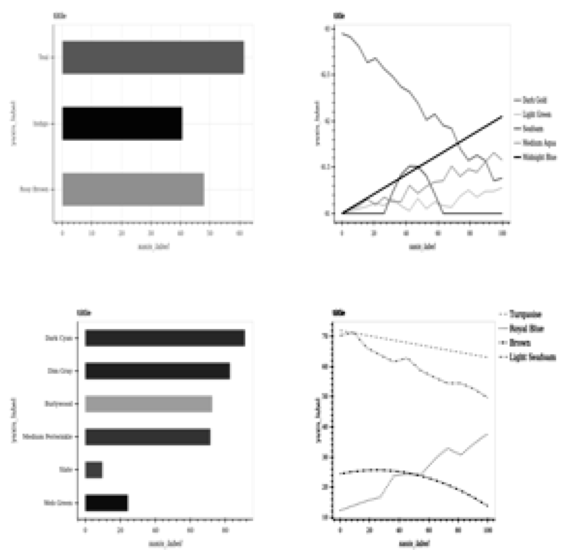

In [ ]:
# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 2
L_grid = 2

# visualizing images
idxs = random.sample(range(len(train_x)), W_grid * L_grid)

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations
fig, axes = plt.subplots(L_grid, W_grid, figsize = (10,10))

axes = axes.ravel() 

for i in range(len(idxs)):
    axes[i].imshow(train_x[idxs[i]], cmap='gray')
    # axes[i].set_title(predictions_string[idxs[i]], fontsize=15)
    axes[i].axis("off")
    
plt.subplots_adjust(hspace = 0.2)

# Splitting the dataset for `testing(20%)` and `training(80%)`

## Splitting the dataset

In [ ]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.2)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((800, 128, 128), (800,)), ((200, 128, 128), (200,)))

## Converting it to tensors

In [ ]:
# converting training images into torch format
train_x = train_x.reshape(800, 1, 128, 128)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
print(train_x.shape)
print(train_y.shape)

torch.Size([800, 1, 128, 128])
torch.Size([800])


In [ ]:
# converting validation images into torch format
val_x = val_x.reshape(200, 1, 128, 128)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
# shape of training data
print(val_x.shape)
print(val_y.shape)

torch.Size([200, 1, 128, 128])
torch.Size([200])


# Implementing CNNs using PyTorch

## CNN Class

In [ ]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 32 * 32, 5)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
#         print(x.shape)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        x = self.linear_layers(x)
        return x

## Train Function

In [ ]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

# Model Training

## Defining Training Parameters

In [ ]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.02)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
# print(model)

## Staring the training

In [ ]:
# defining the number of epochs
n_epochs = 50
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(1.7754, grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(23.7805, grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(12.5377, grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(3.5375, grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(1.3267, grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(0.4614, grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(0.3364, grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(0.0954, grad_fn=<NllLossBackward>)
Epoch :  17 	 loss : tensor(0.0720, grad_fn=<NllLossBackward>)
Epoch :  19 	 loss : tensor(0.0829, grad_fn=<NllLossBackward>)
Epoch :  21 	 loss : tensor(0.1005, grad_fn=<NllLossBackward>)
Epoch :  23 	 loss : tensor(0.0968, grad_fn=<NllLossBackward>)
Epoch :  25 	 loss : tensor(0.0777, grad_fn=<NllLossBackward>)
Epoch :  27 	 loss : tensor(0.0592, grad_fn=<NllLossBackward>)
Epoch :  29 	 loss : tensor(0.0460, grad_fn=<NllLossBackward>)
Epoch :  31 	 loss : tensor(0.0345, grad_fn=<NllLossBackwa

## Plotting the training and validation loss

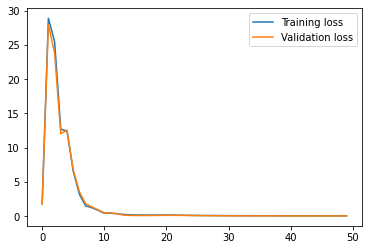

In [ ]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

# Accuracy of the Model

In [ ]:
# prediction for training set
with torch.no_grad():
#     output = model(train_x.cuda())
    output = model(train_x)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
acc = accuracy_score(train_y, predictions) * 100

print(f"Accuracy of the model is : {acc} %")

Accuracy of the model is : 99.0 %


# Test with the Test dataset (unseen data)

## Loading the test data

In [ ]:
test_p = os.path.join(chart_data_path, 'test')
count = 0
for path in pathlib.Path(test_p).iterdir():
    if path.is_file():
        count += 1

In [ ]:
# loading testing  images
test_img = []

for img_name in tqdm(range(count)):
    # defining the image path
    i_name = str(img_name) + '.png'
    image_path = os.path.join(test_p, i_name)

    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    test_img.append(img)

# converting the list to numpy array
test_x = np.array(test_img)
# # defining the target
# train_y = train_val['type'].values
test_x.shape

100%|██████████| 50/50 [00:09<00:00,  5.32it/s]


(50, 128, 128)

In [ ]:
# converting testing images into torch format
test_x_pt = test_x.reshape(count, 1, 128, 128)
test_x_pt  = torch.from_numpy(test_x_pt)


In [ ]:
# prediction for training set
with torch.no_grad():
#     output = model(train_x.cuda())
    output = model(test_x_pt)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())

predictions = np.argmax(prob, axis=1)
predictions_string = [ label_hash[i] for i in predictions]

## Randomly picking 9 image samples from the test data set 

In [ ]:
# Let's view more images in a grid format
# Define the dimensions of the plot grid 

# This will randomly pick 9 image samples, if you want 16, then change W_grid = 4 and L_grid = 4

W_grid = 3                  
L_grid = 3

## Visulizing  the samples with the `chart title` as the `prediction` 

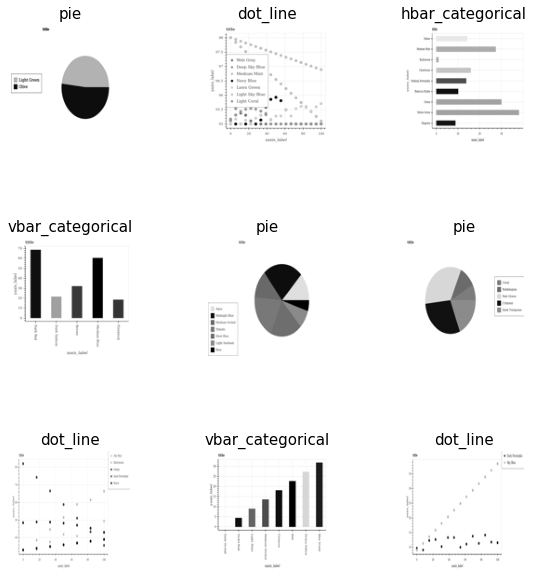

In [ ]:
# visualizing images
idxs = random.sample(range(count), W_grid * L_grid)

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations
fig, axes = plt.subplots(L_grid, W_grid, figsize = (10,10))

axes = axes.ravel() 

n_training = len(test_x_pt) # get the length of the training dataset

for i in range(len(idxs)):
    axes[i].imshow(test_x[idxs[i]], cmap='gray')
    axes[i].set_title(predictions_string[idxs[i]], fontsize=15)
    axes[i].axis("off")
    
plt.subplots_adjust(hspace = 0.8)

# Conclusion

We observe that with the model is give a accuracy of ~ 94%-99% 

With 2 convolution layers, ReLU activation and Maxpooling
